In [1]:
from collections.abc import Callable, Iterator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy import stats

In [2]:
def get_statistics(f):
    def wrapper(self, *args, **kwargs):
        class Report:
            def __init__(self, data: np.array, statistics: pd.DataFrame = None) -> None:
                self.data = data
                self.statistics = statistics

        res = f(self, *args, **kwargs)
        return_statistics = kwargs.get("return_statistics", True)
        if not return_statistics:
            self.last_original_data = res
            self.last_statistics = None
            return Report(res)

        strategy_name = kwargs.get("strategy_name")
        n = kwargs.get("n")
        iteration = kwargs.get("iteration")
        minimum = np.min(res)
        maximum = np.max(res)
        positive_count = np.sum(res > 0)
        negative_count = np.sum(res < 0)
        mean = np.mean(res)
        median = np.median(res)
        std = np.std(res)
        cv = std / np.abs(mean)
        statistics = {
            "# of Rounds": n,
            "Iteration": iteration,
            ">0": positive_count,
            "<0": negative_count,
            "Min": minimum,
            "Max": maximum,
            "Mean": mean,
            "Median": median,
            "Standard Deviation": std,
            "CV(Coefficient of Variance)": cv,
        }
        df = pd.DataFrame.from_dict(statistics, orient="index")
        df.columns = [f"Strategy{self.strategy_count:03d}: {strategy_name}"]

        self.last_original_data = res
        self.last_statistics = df
        return Report(res, df)

    return wrapper

In [54]:
class Toss:
    id = 0

    def __init__(self, HH: float = 3, TT: float = 1, HT: float = 2) -> None:
        self.strategy_count = 0
        self.HH = HH
        self.TT = TT
        self.HT = HT
        self.c2ab = HT**2 > HH * TT
        self.A = HH + TT + 2 * HT
        self.B = -TT - HT
        self.C = -TT - HT
        self.D = TT
        self.y = self.B / self.A
        self.f = lambda x, y: self.A * x * y + self.B * x + self.C * y + self.D
        self.f_text = f"{self.A} x y + {self.B} x + {self.C} y + {self.D}, 0 <= x <= 1, 0 <= y <= 1"
        self.saddle_point = f"({self.y:.05f}, {self.y:.05f}, {self.f(self.y,self.y)})"

        self.last_original_data = None
        self.last_statistics = None
        Toss.id += 1

    def report(f):
        def wrapper(self, *args, **kwargs):
            print(f"Initial Condition {Toss.id:03d}")
            print(f"\tf(x,y) = {self.f_text}")
            area = sum(*self.calculate_area())
            if self.c2ab == 0:
                positive_area, negative_area = 1 / 2, 1 / 2
            info = {
                "HH": self.HH,
                "TT": self.TT,
                "HT/TH": self.HT,
                "Saddle point": self.saddle_point,
                "(HT/TH)^2 > HH*TT": self.c2ab,
            }
            df = pd.DataFrame.from_dict(info, orient="index").T
            display(df)

            return f(self, *args, **kwargs)

        return wrapper

    def calculate_area(self):
        A, B, C, D = self.A, self.B, self.C, self.D
        E = B * C - A * D
        # x1 = -D / B
        # x2 = (-C - D) / (A + B)
        # if x1 == x2:
        #     return 1 / 4, 1 / 4
        # if x1 < x2:
        #     integral1 = D / A + E / A**2 * np.log(np.abs(E / B / C))
        #     integral2 = -(B / A) * (A + B + C + D) / (A + B) + E / A**2 * np.log(
        #         np.abs((A + C)(A + B) / E)
        #     )
        # if x1 > x2:
        #     integral1 = -(B + D) / A + E / A**2 * np.log(np.abs(B * (A + C) / E))
        #     integral2 = (B / A) * (C + D) / (A + B) + E / A**2 * np.log(
        #         np.abs(E / C / (A + B))
        #     )
        x1 = -D / B
        x2 = (-C - D) / (A + B)
        # if not self.c2ab:
        #     x1, x2 = x2, x1
        integral1 = -(B / A) * x1 + E / A**2 * np.log(np.abs((A * x1 + C) / C))
        integral2 = -(B / A) * (1 - x2) + E / A**2 * np.log(
            np.abs((A + C) / (A * x2 + C))
        )

        print(integral1, integral2)
        return integral1, 1 - x2 - integral2

    def calculate_gap(self):
        A, B, C, D = self.A, self.B, self.C, self.D
        E = B * C - A * D
        x1 = -D / B  # f(x1, 0) = 0
        y1 = -D / C  # f(0, y1) = 0
        x2 = (-C - D) / (A + B)  # f(x2, 1) = 0
        y2 = (-B - D) / (A + C)  # f(1, y2) = 0
        return y1, y2, y2 - y1

    def display_project_on_z(
        self,
        density: int = 100,
        condition_z: Callable[[np.array], bool] = lambda z: z <= 0,
    ):
        density = int(density)
        x = np.linspace(0, 1, density)
        y = np.linspace(0, 1, density)
        x, y = np.meshgrid(x, y)
        z = np.vectorize(self.f)(x, y)

        mask = condition_z(z)
        x = x[mask]
        y = y[mask]
        plt.scatter(x, y)

    @report
    @get_statistics
    def toss_independent(
        self,
        your_probability_HH: float,
        n: int = 1,
        iteration: int = 1,
        strategy_name: str = "",
        return_statistics: bool = True,
    ) -> np.array:
        n = int(n)
        iteration = int(iteration)

        res = []
        for _ in range(iteration):
            A = np.random.choice([0, 1], size=n, p=[self.y, 1 - self.y])
            B = np.random.choice(
                [0, 1], size=n, p=[your_probability_HH, 1 - your_probability_HH]
            )

            lookup_table = np.array([[self.HH, -self.HT], [-self.HT, self.TT]])
            res.append(lookup_table[A, B].sum())

        self.strategy_count += 1
        self.last_original_data = np.array(res)
        return np.array(res) / n

    @report
    @get_statistics
    def toss_generative(
        self,
        your_strategy: Callable[[np.array], np.array],
        n: int = 1,
        iteration: int = 1,
        strategy_name: str = "",
        return_statistics: bool = True,
    ) -> np.array:
        n = int(n)
        iteration = int(iteration)

        res = []
        for _ in range(iteration):
            A = np.random.choice([0, 1], size=n, p=[self.y, 1 - self.y])
            B = your_strategy(A)

            lookup_table = np.array([[self.HH, -self.HT], [-self.HT, self.TT]])
            res.append(lookup_table[A, B].sum())

        self.strategy_count += 1
        self.last_original_data = np.array(res)
        return np.array(res) / n

In [56]:
toss = Toss(HH=3, TT=1, HT=2)
# toss.display_project_on_z(density=1e4)
toss.calculate_area()

0.09066836597912158 0.2752949347635656


(0.09066836597912158, 0.3247050652364344)

In [24]:
toss.calculate_gap()

(0.3333333333333333, 0.4, 0.06666666666666671)

Initial Condition 001
	f(x,y) = 8 x y - 3 x - 3 y + 1, 0 <= x <= 1, 0 <= y <= 1


,HH,TT,HT/TH,Saddle point,(HT/TH)^2 > HH*TT
0,3,1,2,"(0.37500, 0.37500, -0.125)",True


,Strategy001: H:T = 1:1
# of Rounds,10000.000000
Iteration,10000.000000
>0,0.000000
<0,10000.000000
Min,-0.200100
Max,-0.043100
Mean,-0.125108
Median,-0.125000
Standard Deviation,0.020025
CV(Coefficient of Variance),0.160059


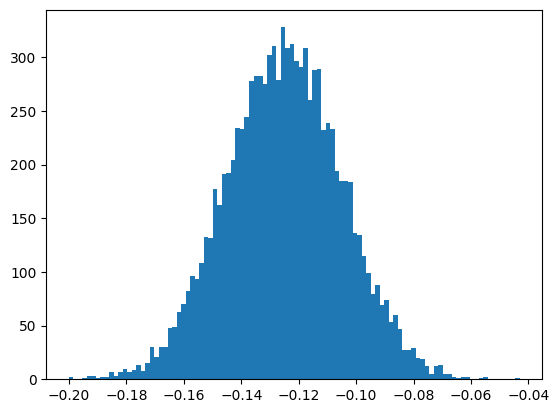

In [5]:
toss1 = toss.toss_independent(
    1/2,
    strategy_name="H:T = 1:1",
    n=1e4,
    iteration=1e4,
)
plt.hist(toss1.data, bins=100)
toss1.statistics

Initial Condition 001
	f(x,y) = 8 x y - 3 x - 3 y + 1, 0 <= x <= 1, 0 <= y <= 1


,HH,TT,HT/TH,Saddle point,(HT/TH)^2 > HH*TT
0,3,1,2,"(0.37500, 0.37500, -0.125)",True


,Strategy002: H:T = 3:5
# of Rounds,10000.000000
Iteration,10000.000000
>0,0.000000
<0,10000.000000
Min,-0.196800
Max,-0.051000
Mean,-0.125171
Median,-0.125300
Standard Deviation,0.018808
CV(Coefficient of Variance),0.150254


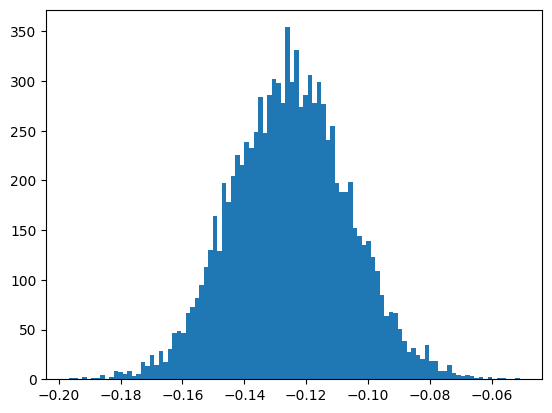

In [6]:
toss2 = toss.toss_independent(
    3 / 8,
    strategy_name="H:T = 3:5",
    n=1e4,
    iteration=1e4,
)
plt.hist(toss2.data, bins=100)
toss2.statistics

Initial Condition 001
	f(x,y) = 8 x y - 3 x - 3 y + 1, 0 <= x <= 1, 0 <= y <= 1


,HH,TT,HT/TH,Saddle point,(HT/TH)^2 > HH*TT
0,3,1,2,"(0.37500, 0.37500, -0.125)",True


,Strategy003: H:T = 5:3
# of Rounds,10000.000000
Iteration,10000.000000
>0,0.000000
<0,10000.000000
Min,-0.210500
Max,-0.049000
Mean,-0.124897
Median,-0.125100
Standard Deviation,0.020789
CV(Coefficient of Variance),0.166447


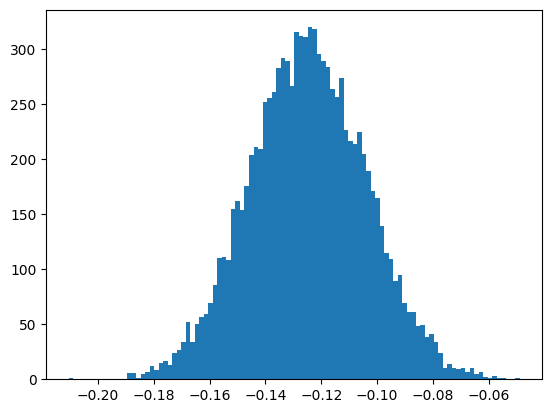

In [7]:
toss3 = toss.toss_independent(
    5 / 8,
    strategy_name="H:T = 5:3",
    n=1e4,
    iteration=1e4,
)
plt.hist(toss3.data, bins=100)
toss3.statistics

Initial Condition 001
	f(x,y) = 8 x y - 3 x - 3 y + 1, 0 <= x <= 1, 0 <= y <= 1


,HH,TT,HT/TH,Saddle point,(HT/TH)^2 > HH*TT
0,3,1,2,"(0.37500, 0.37500, -0.125)",True


,Strategy004: TFT
# of Rounds,10000.000000
Iteration,10000.000000
>0,0.000000
<0,10000.000000
Min,-0.197100
Max,-0.057900
Mean,-0.124960
Median,-0.124900
Standard Deviation,0.018778
CV(Coefficient of Variance),0.150271


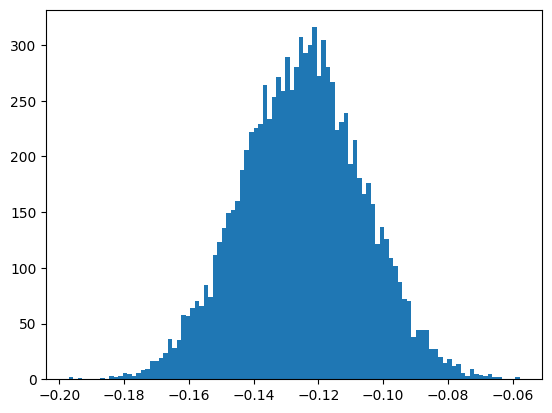

In [8]:
def TFT(history: np.array, initial: int = 0):
    shifted_arr = np.roll(history, 1)
    shifted_arr[0] = initial
    return shifted_arr


toss4 = toss.toss_generative(
    TFT,
    strategy_name="TFT",
    n=1e4,
    iteration=1e4,
)
plt.hist(toss4.data, bins=100)
toss4.statistics